In [15]:
# Setup code. Make sure you run this first!

import os
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

data_dir = '../input/movielens_preprocessed'
# TODO: right now using a 10% subset of dataset so training isn't too slow. Should maybe mention this.
df = pd.read_csv(os.path.join(data_dir, 'mini_rating.csv')).sample(frac=1)

history_FS = (15, 5)
def plot_history(histories, keys=('loss', 'mean_absolute_error'), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])

print("Setup complete!")

Setup complete!


In this exercise, we're going to try adding an enhancement to the embedding model I trained in the previous lesson. To start, let's train a model with the same parameters so we have a baseline to compare against:

In [ ]:
# Training without bias

tf.set_random_seed(1); np.random.seed(1); random.seed(1)
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)
history = model.fit(
    [df.userId, df.movieId],
    df.rating,
    batch_size=10**3,
    epochs=15,
    verbose=0,
    validation_split=.05,
);
#plot_history([ ('no_bias', history) ]);

# Exercise (embeddings)

I propose an improvement to the model we trained in the tutorial: per-movie biases. In ML-speak, a **bias** is just a number that gets added to a node's output value. For each movie, we'll learn a single number that we'll add to the output of what was previously our final node. Here's what that looks like:

**TODO: diagram**

```
Editor's note: I was hoping that adding biases would actually help accuracy to some degree. It turns out it doesn't really. 

I'm inclined to still keep this exercise as is. Negative results are still results. And it gives good practice with embedding layers.

Still, kind of anticlimactic.

The thing that saves it might be the last (optional) part on smart initialization. Even if it doesn't improve the final error, I'm pretty sure it gives a very obvious headstart to convergence, which is a nice little trick to have available.

If we wanted to do something completely different, could have them train a model on a different dataset, such as https://www.kaggle.com/zygmunt/goodbooks-10k/home, which looks like a pretty great drop-in replacement.
Though, how do we make it more interesting than just copy-pasting and changing some variable names?
```

## Part 1: Why?

Can you think of why this might improve our predictions? Do you have an idea about what the bias values will look like? Are there certain movies you expect will have high or low biases?

Think about it, then uncomment the line below to see an explanation.

In [ ]:
#q1.solution()
"""
Some movies are, on average, rated significantly higher or lower than others. 
In the tutorial, I mentioned that predicting the average rating per-movie gave much
better results than always predicting the global average. Per-movie biases are a simple
way for our model to account for the relative goodness or badness of movies. 

If the model does utilize the biases in this way, then we should expect the highest biases
to go to highly acclaimed movies like *The Godfather* or *Schindler's List*, and the lowest
biases to go to stinkers like *Battlefield Earth* or *Sharknado*.
"""

## Part 2: Coding it up

Below is the code we used to train our embedding model in the tutorial. Modify it (where indicated by the comments) to add per-movie biases.

In [5]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

# TODO: you need to create the variable movie_bias. Its value should be the output of calling a layer.
#movie_bias = 
out = keras.layers.Add()([out, movie_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)
model.summary()

No idea where to start? Don't panic! Uncomment and run the line below for some hints.

In [ ]:
#q2.hint()
"""
1. Surprisingly, this is another use case for an embedding layer. Check out the docs 
on [keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
to review its parameters.
2. As with our existing use of Embedding layers, you may need to flatten its output to get rid of 
an extra dimension.
"""

In [17]:
#q2.solution()
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name='bias',
                                      )(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, movie_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         108544      user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         133720      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

## Part 3: Training

Run the code below to train the model you built in the previous step.

In [18]:
history_bias = model.fit(
    [df.userId, df.movieId],
    df.rating,
    batch_size=10**3,
    epochs=15,
    verbose=2,
    validation_split=.05,
);

Train on 1900000 samples, validate on 100000 samples
Epoch 1/15
 - 11s - loss: 0.8336 - mean_absolute_error: 0.6990 - val_loss: 0.7536 - val_mean_absolute_error: 0.6699
Epoch 2/15
 - 11s - loss: 0.7342 - mean_absolute_error: 0.6593 - val_loss: 0.7330 - val_mean_absolute_error: 0.6531
Epoch 3/15
 - 9s - loss: 0.7054 - mean_absolute_error: 0.6448 - val_loss: 0.7117 - val_mean_absolute_error: 0.6501
Epoch 4/15
 - 9s - loss: 0.6866 - mean_absolute_error: 0.6357 - val_loss: 0.7030 - val_mean_absolute_error: 0.6411
Epoch 5/15
 - 10s - loss: 0.6719 - mean_absolute_error: 0.6285 - val_loss: 0.6958 - val_mean_absolute_error: 0.6382
Epoch 6/15
 - 7s - loss: 0.6573 - mean_absolute_error: 0.6212 - val_loss: 0.6890 - val_mean_absolute_error: 0.6372
Epoch 7/15
 - 8s - loss: 0.6455 - mean_absolute_error: 0.6154 - val_loss: 0.6880 - val_mean_absolute_error: 0.6380
Epoch 8/15
 - 7s - loss: 0.6349 - mean_absolute_error: 0.6101 - val_loss: 0.6875 - val_mean_absolute_error: 0.6305
Epoch 9/15
 - 7s - loss:

How does it compare to the results we got from the model without biases? Run the code cell below to compare their loss over the course of training.

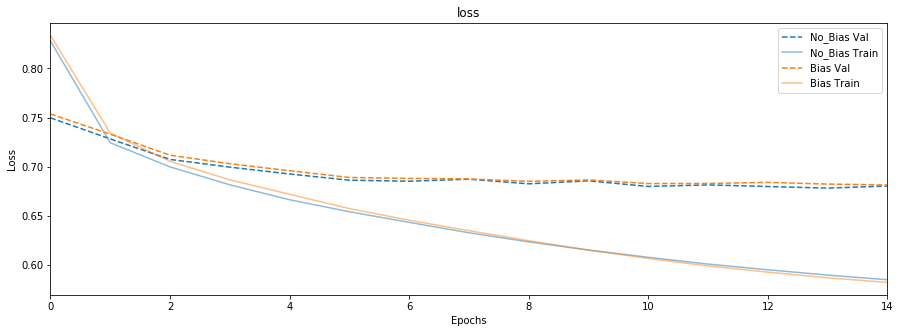

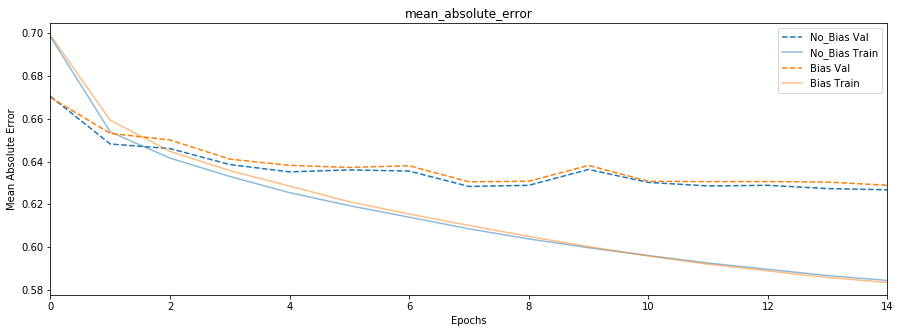

In [19]:
plot_history([ 
    ('no_bias', history),
    ('bias', history_bias),
]);

**TODO: Should have some remark on these results (especially since they violate our hypothesis that adding biases would help)**

## Part 4: Exploring biases

Run the cell below to load the bias values learned by the model and add them to a dataframe containing movie metadata.

**TODO: turn this into a question. i.e. ask them to find the movies with the highest/lowest biases. Ask them to implement (or complete the implementation of) a scatterplot of mean rating vs. bias**

In [49]:
bias_layer = model.get_layer('bias')
(b,) = bias_layer.get_weights()
print(b.shape)

movies = pd.read_csv(os.path.join(data_dir, 'movie.csv'), index_col=0, usecols=['title', 'genres', 'movieId_orig',
                                                                                'year',
                                                                               ])

mids = df.groupby('movieId')['movieId_orig'].first()
mo_to_bias = pd.DataFrame(b, index=mids.values, columns=['bias'])

movies = movies.merge(mo_to_bias, left_on='movieId_orig', right_index=True)

# Add columns for number of ratings and average rating
mean_ratings_mini = df.groupby('movieId_orig')['rating'].mean().rename('mean_rating').to_frame()
movies = movies.merge(mean_ratings_mini, left_on='movieId_orig', right_index=True)

n_ratings_mini = df.groupby('movieId_orig').size().rename('n_ratings').to_frame()
movies = movies.merge(n_ratings_mini, left_on='movieId_orig', right_index=True)
movies.head()

(16715, 1)


In [51]:
movies.sort_values(by='bias').head(10)

,genres,movieId_orig,year,bias,mean_rating,n_ratings
title,,,,,,
Gray Lady Down,Drama|Thriller,8649,1978,-1.899126,0.500000,2
Moonlight Mile,Drama|Romance,5625,2002,-1.670015,0.900000,5
The Train,Action|Thriller|War,26148,1964,-1.465848,1.000000,1
My Baby's Daddy,Comedy,7170,2004,-1.414928,0.750000,2
The Major and the Minor,Comedy|Romance,8336,1942,-1.361825,0.875000,4
Stealing Harvard,Comedy|Crime,5573,2002,-1.351372,1.297297,37
Uncle Buck,Comedy,4679,1989,-1.238894,1.245614,57
Pauline at the Beach (Pauline à la Plage),Comedy|Drama|Romance,6241,1983,-1.221575,0.500000,1
Chopper,Drama|Thriller,4251,2000,-1.212525,1.250000,2


In [52]:
movies.sort_values(by='bias', ascending=False).head(10)

,genres,movieId_orig,year,bias,mean_rating,n_ratings
title,,,,,,
Little Black Book,Comedy|Romance,8799,2004,2.212671,5.0,1
White Zombie,Horror,7881,1932,2.128701,5.0,1
"Short Film About Killing, A (Krótki film o zabijaniu)",Crime|Drama,8656,1988,2.094837,5.0,1
Whose Life Is It Anyway?,Drama,5916,1981,1.968613,5.0,1
Night of the Demons,Horror,8854,1988,1.856783,4.5,1
The Terminal,Comedy|Drama|Romance,8529,2004,1.835711,4.5,1
Revenge,Drama|Romance|Thriller,7032,1990,1.832188,4.5,1
"Easy Life, The (Il Sorpasso)",Comedy|Drama,26090,1962,1.817918,4.5,2
"Passion of Joan of Arc, The (Passion de Jeanne d'Arc, La)",Drama,6985,1928,1.809291,4.0,1


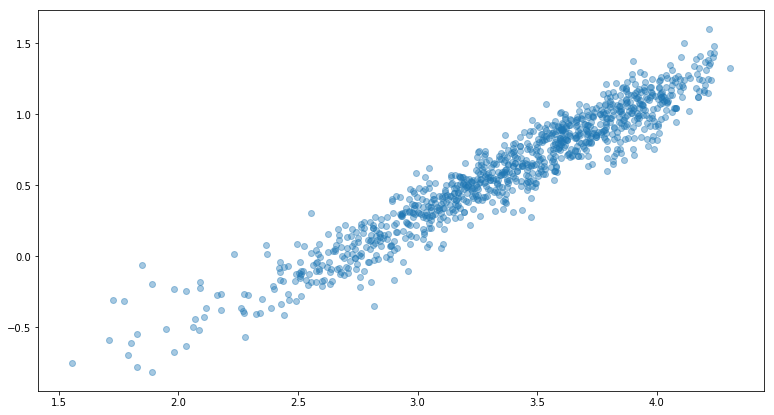

In [53]:
n = 1000
mini = movies[movies.n_ratings >= 100].sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.4);

**TODO: commentary**

## Part 5: (BONUS) Giving biases a head-start

```
TODO: still need to fill this part in. Idea is to try 'intelligently' initializing biases according to the data means. Show how we can specify custom initializers when creating Keras layers. 

Then train, and see what effect this has. (Expected effect is better accuracy at the beginning / faster convergence)
```

# Scratch space. Other exercise ideas.

## Experimenting with embedding sizes

In the lesson, we (fairly arbitrarily) chose an embedding size of 8 for both movies and users. The size of embeddings is a hyperparameter we can experiment with to improve our results. Larger embeddings give the model more capacity, meaning they can potentially learn more detailed representations. On the other hand, it increases the model's ability to 'memorize' details of the training data that don't generalize well to unseen data.

Note that the size of our movie embeddings and our user embeddings need not be the same. Do you have a hunch about whether one should have bigger embeddings than the other?

Try experimenting with a few different embedding sizes. Can you improve our loss on the validation data? How do different embedding sizes affect the training loss?

Hint: [this TensorFlow tutorial](https://www.tensorflow.org/guide/feature_columns) gives a general rule of thumb for setting the embedding size of a categorical variable: the 4th root of the number of possible values.

## . adding auxiliary features

(Note: question of how to incorporate genre is actually a great prelude to the stuff talked about in the cooking problem. Movies have varying numbers of genre tags, so need some way to deal w/ variable-sized bags of categorical variables. Padding, combining embeddings. Just like cooking problem.)

## . Movie embeddings only (thought experiment)

Mary the movie buff has decided to train a variant of our model. She thinks that movies have a lot of interesting dimensions of variation, and are highly useful for our prediction task, so she allocates a lot more capacity for them - she increases the embedding size from 32 to 128.

On the other hand, she thinks that differences between users are too small to pick out from the noise, so she doesn't train any user embeddings at all.

There's a fundamental issue with her model. Do you see what it is? How would you explain it to her?

*Solution:* Regardless of how big she makes the embeddings, or how many hidden layers she adds, as long as her model only takes movie ids as inputs, it's equivalent to a simple linear model that learns one rating per movie id. Therefore, she might as well just train a simple linear regression model directly - or even calculate the optimal values per movie directly, which is just its mean rating. 

## . clamping output range (spicy)

We know that ratings can only ever take on the values `{0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}`.

Can we help our model out by forcing its output into that range? Should we?

### pt. 1

If our model makes a prediction less than 0.5, we're guaranteed to get a better result if we bump it up to 0.5. Similarly if it makes predictions above 5.0. But is it doing this? 

Calculate some predictions on the training data and on the validation data. Do you see any predictions outside the range `[0.5, 5.0]`? 

### pt2. 

Modify the code below to prevent the model from making predictions outside the allowable range of outputs, then try training it. How do results compare to the original model?

Solution: Change the final layer's activation from linear to a function with a fixed range (sigmoid or tanh). From there, you'll need to use a Lambda Layer to scale the output range to `[0.5, 5]` by some addition and multiplication. Alternatively: scale the `y` values ahead of time to the range `[0, 1]` (or `[-1, 1]`, if using tanh). But note: now the reported MSE/MAE is not comparable to our other models.


## other

- r12n. encouraging sparsity
- prediction debugging
- thought experiment: regression v multiclass classification